<a href="https://www.kaggle.com/code/sajeevyadav/image-classification-rapids-random-forest?scriptVersionId=118701865" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/mnist-dataset-digit-recognizer/mnist_submission.csv
/kaggle/input/mnist-dataset-digit-recognizer/__results__.html
/kaggle/input/mnist-dataset-digit-recognizer/__output__.json
/kaggle/input/mnist-dataset-digit-recognizer/custom.css


**Sajeev Yadav
102016073
3CS11**

In [2]:
!nvidia-smi

Thu Feb  9 17:50:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip3 install rapids
!pip3 install cuml


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.2/254.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.0/115.0 kB 8.1 MB/s eta 0:00:00


In [4]:
import cudf 
import cuml 
import cupy 


## IMPORT DATASET

In [5]:
df_train=pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
df_test=pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [6]:
df_train=df_train.astype('float32')
df_test=df_test.astype('float32')

In [7]:
df_train.pixel0

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
41995    0.0
41996    0.0
41997    0.0
41998    0.0
41999    0.0
Name: pixel0, Length: 42000, dtype: float32

In [8]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Preprocessing

In [9]:
Y=df_train['label']
X=df_train.drop(['label'],axis=1)

In [10]:
X.pixel0

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
41995    0.0
41996    0.0
41997    0.0
41998    0.0
41999    0.0
Name: pixel0, Length: 42000, dtype: float32

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,train_size=0.8)

In [13]:
y_train.value_counts()

1.0    3724
7.0    3530
3.0    3499
9.0    3337
6.0    3321
2.0    3320
8.0    3288
0.0    3284
4.0    3270
5.0    3027
Name: label, dtype: int64

## MODEL BUILDING

In [14]:
from cuml.ensemble import RandomForestClassifier 
# n_estimators
# split_criterion
# bootstrap
# max_samples
# max_depth
# max_leaves
# max_features
# max_batch_size
# min_samples_split

In [15]:
rfc=RandomForestClassifier()
rfc.fit(X_train,y_train)


RandomForestClassifier()

In [16]:
y_pred=rfc.predict(X_test)

In [17]:
from sklearn.metrics import accuracy_score

In [18]:
accuracy_score(y_test,y_pred)

0.9652380952380952

In [19]:
df_test=df_test.astype('float32')

In [20]:
y_test=rfc.predict(df_test)

<AxesSubplot:>

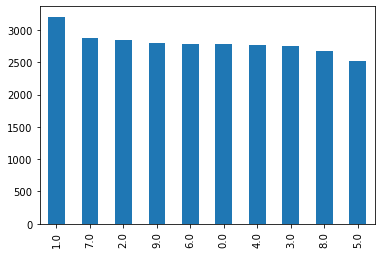

In [21]:
pd.Series(y_test).value_counts().plot(kind='bar')